# Build a model to classify topics for Telegram channels

**Pre-req**
1. Download csv from gdrive with channels and save to ``data/external/telegram_channels.csv``
2. Run ``python -m src.train.download`` to get posts and meta-data

**Steps**
1. Load data:
    - posts from channels
    - channel titles and descriptions
    - channel topics
2. Build a training dataset:
    1. Merge
    2. Select inputs
    3. Split into train/val
3. Build models:
    1. Embed text
    2. Train a classifier
    3. Select best
4. Evaluate on test data and save best

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
#standard libs
import os, sys
from pathlib import Path
from pprint import pprint
from collections import Counter
import random
import json
import itertools
from datetime import datetime as dt
# ds libs
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm, tqdm_notebook

from torchtext import data
import re
# custom path
os.chdir('..')
os.environ['KMP_DUPLICATE_LIB_OK']='True'


In [360]:
# %%writefile src/train/text_utils.py
import re
import pyonmttok
from src.train.nlp_utils import load_lemmatizers, get_tokens, select_lemmas


def process_topics(topics):
    ''' remove empty ones and strip from whitespaces '''
    topics = list(filter(lambda x: x != '', 
                        topics))
    topics = list(map(lambda x: x.strip(), topics))
    return topics


def raw2list(raw):
    """convert raw str or dict field to a list of topics """
    if isinstance(raw, dict):
        raw = raw['choices']
    else:
        raw = [str(raw)]
    return raw


def get_test_topics(primary, secondary):
    """ merge primary and secondary """
    primary = raw2list(primary)
    if secondary != '':
        primary += raw2list(secondary)
    return primary


def prepare_inputs(channel_data, target_fields):
    """ receive one channel example and return its texts from title, description and posts """
    inputs = []
    if 'title' in target_fields:
        inputs.append(channel_data['title'])
    if 'description' in target_fields:
        inputs.append(channel_data['description'])
    if 'posts' in target_fields:
        inputs += list(channel_data['posts'])
    return '\n'.join(inputs)


def clean_token(token):
    """ keep only english or russian characters """
#     re.sub('[\W\d]', '', x)
    token = re.sub('[^a-zа-я]', '', token)
    return token


def process_tokens(tokens):
    """filter out useless tokens as empty or non-words"""
    tokens = list(map(lambda x: clean_token(x),
                     tokens))
    tokens = list(filter(lambda x: len(x) > 1,
                    tokens))
    return tokens


TOKENIZER = pyonmttok.Tokenizer('aggressive', joiner_annotate=True)


def preprocess_text(text):
    """remove url, non-words chars """
    text = re.sub('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+',
             " ", text)
    return text.lower()

def tokenize_text(text):
    """ split into lowercase tokens """
    text = preprocess_text(text)
    text = re.sub('\n+', ' ', text)
    tokens,_ = TOKENIZER.tokenize(text)
    tokens = process_tokens(tokens)
    return tokens


POS = {
    "en": ['NOUN', 'PROPN', 'ADJ', 'VERB'],
    "ru": ['A', 'S',]
}

load_lemmatizers()


def lang_lemmatizer(language):
    def lemmatize_text(text):
        """ get lemmas and POS tags, select target POS lemmas and filter trash """
        text = preprocess_text(text)
        tokens = get_tokens(text, language)
        lemmas = select_lemmas(tokens, POS[language])
        lemmas = process_tokens(lemmas)
        return lemmas
    return lemmatize_text

## Data prep

In [761]:
POSTS = 'data/raw/posts.csv'
META = 'data/raw/meta.csv'
TOPICS = 'data/external/telegram_channels.csv'

COMPLETIONS = [
    'data/external/2020-02-14_completions.json',
    'data/external/2020-02-14_active_completions.json',
]
ACTIVE_COMPLETIONS = [
#     'data/external/2020-02-14_active_completions.json'
]


ONLY_PRIMARY = False
MIN_RAND = 2

### Load channels

In [762]:
posts = pd.read_csv(POSTS)
meta = pd.read_csv(META)
topics = pd.read_csv(TOPICS)

# extra columns
topics['topic [Secondary]'].fillna("", inplace=True)
topics['username'] = topics['link'].apply(lambda x: x.split('/')[-1])

topics['language'] = topics['language'].apply(lambda x: x.lower()[:2])

posts.rename({'channel':'username', 'message': 'posts'}, axis=1, inplace=True)

if ONLY_PRIMARY:
    topics['topics'] = topics.apply(lambda x: x['topic [Primary]'].split(','), axis=1)
else:
    topics['topics'] = topics.apply(lambda x: x['topic [Primary]'].split(',') + x['topic [Secondary]'].split(','), 
                               axis=1)
topics['topics'] = topics['topics'].apply(process_topics)
posts['posts'].fillna("", inplace=True)

meta['description'] = meta['about']
meta['description'].fillna('', inplace=True)


del topics['link'], meta['about']

In [763]:
posts.sample(4)

,username,idx,date,posts,language
727,ithumor,4932,2021-02-13 17:03:04+00:00,​Когда в твоём проекте много багов и ты решил ...,ru
3595,carsoftheworld,4610,2020-10-25 21:36:22+00:00,,en
1286,masyashpakofficial,1046,2021-02-12 03:41:29+00:00,"February 12, 2021 at 05:54AM\n\nНу, с Богом ✈ч...",ru
4120,freelancetaverna,4734,2021-02-12 16:50:34+00:00,#другое\n\nИщут специалистов по расчётам КП.\n...,ru


In [764]:
meta.sample(3)

,username,title,description
329,oneminutevid,One Minute Motivation,Are you sometimes weighed down by difficulties...
248,wallknight,Wall Papers,Daily hd wallpapers for your home screen.\n\n#...
240,apodChannel,Astronomy Picture Of the Day,Astronomy Picture Of the Day\nA different astr...


In [765]:
topics.sample(5)

,Timestamp,topic [Primary],language,topic [Secondary],username,topics
143,2/8/2021 7:35:08,Economy & Finance,ru,,biz_FM,[Economy & Finance]
15,2/11/2021 16:36:23,Offers & Promotions,en,Food & Cooking,foodcoupon,"[Offers & Promotions, Food & Cooking]"
387,2/3/2021 7:49:08,Sports,ru,,footballworld2019,[Sports]
409,2/3/2021 7:18:40,Books,ru,,biblio,[Books]
419,2/3/2021 7:04:24,Movies,ru,,FilmsFHD,[Movies]


### EDA

In [766]:
from src.train.plot_utils import barplots

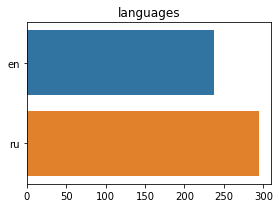

In [767]:
barplots({
    'languages': topics['language']
}, 1, 1)

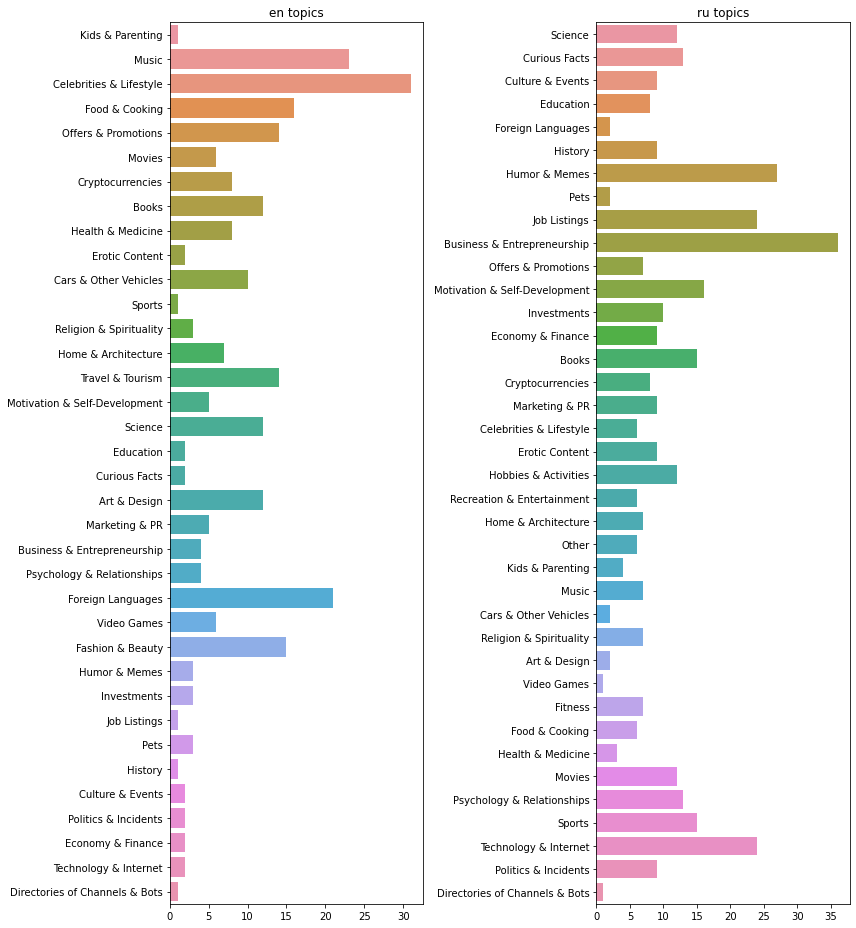

In [768]:
t = topics.groupby('language').agg({
    'topics': lambda rows: Counter(x for row in rows for x in row)
}).to_dict()['topics']

barplots({
    'en topics': (list(t['en'].keys()), list(t['en'].values())),
    'ru topics': (list(t['ru'].keys()), list(t['ru'].values())),
}, 1, 2, fig_dims=(12,13))

In [769]:
posts.groupby('language').agg({'username':['count', 'nunique']})

username        
            count nunique
language                 
en           2256     227
ru           2774     278

### Compare raw tokens to lemmas

In [770]:
row = posts.sample(1).iloc[0]

lem = lang_lemmatizer(row['language'])
l = lem(row['posts'],)
t = tokenize_text(row['posts'])

print("INPUT", row['posts'], end='\n\n')
print("LEMMAS", l)
# pprint(l)
print('\nRAW TOKENS', t)
# pprint(t)

INPUT 

LEMMAS []

RAW TOKENS []


### Build a dataframe

In [771]:
train_channels = topics[['username', 'topics', 'language']].to_dict('records')
channel_meta = meta.groupby('username').agg({
                            'title': 'first',
                            'description': 'first'
                            }).to_dict('index')

len(train_channels), len(channel_meta)

(532, 505)

In [772]:
inputs = []

for channel in tqdm_notebook(train_channels, desc='channels'):
    channel_name = channel['username']
    subset = posts.query(f'username == "{channel_name}"')['posts']
    num_smp = min(len(subset), np.random.randint(MIN_RAND, 10))
    smp = subset.sample(num_smp).tolist()
    for top in channel['topics']:
        one = {
            'username': channel_name,
            'language': channel['language'],
            'posts': smp,
            'title': channel_meta.get(channel_name, {}).get('title', ''),
            'description': channel_meta.get(channel_name, {}).get('description', ""),
            'topic': top,
        }
        inputs.append(one)
    
inputs = pd.DataFrame(inputs)


inputs.shape

/Users/rustem.galiullin/miniconda3/envs/tgcat/lib/python3.7/site-packages/ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


channels:   0%|          | 0/532 [00:00<?, ?it/s]

(639, 6)

### Test data

In [773]:
def load_labelled_data(files):
    if len(files) == 0:
        return pd.DataFrame()
    labelled_data = [pd.read_json(c, ) for c in files]
    labelled_data = pd.concat(labelled_data)
    labelled_data['secondary'].fillna('', inplace=True)
    labelled_data['username'] = '???'
    del labelled_data['posts']
    labelled_data.rename({'lang_code': 'language', 'recent_posts': 'posts'}, axis='columns', inplace=True)
    labelled_data.info()
    return labelled_data

def prepare_labelled_data(labelled_data):
    labelled_data['topics'] = labelled_data.apply(lambda x: get_test_topics(x['primary'], 
                                                                    '' if ONLY_PRIMARY else x['secondary']),
                                      axis=1)
    data = []
    for i, row in labelled_data.iterrows():
        for top in row['topics']:
            row['topic'] = top
            data.append(row)
    data = pd.DataFrame(data)
    return data

In [774]:
random_labels = load_labelled_data(COMPLETIONS)
# active_labels = load_labelled_data(ACTIVE_COMPLETIONS)

# del active_labels['score'], active_labels['predictions']

<class 'pandas.core.frame.DataFrame'>
Int64Index: 691 entries, 0 to 282
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   description  691 non-null    object 
 1   language     691 non-null    object 
 2   posts        691 non-null    object 
 3   title        691 non-null    object 
 4   id           691 non-null    int64  
 5   primary      691 non-null    object 
 6   secondary    691 non-null    object 
 7   predictions  283 non-null    object 
 8   score        283 non-null    float64
 9   username     691 non-null    object 
dtypes: float64(1), int64(1), object(8)
memory usage: 59.4+ KB


In [775]:
random_labels.groupby('language').agg({
    'language': 'count',
}).to_dict()

{'language': {'en': 324, 'ru': 367}}

In [776]:
test_data = prepare_labelled_data(random_labels)
# active_data = prepare_labelled_data(active_labels)

test_data.shape #, active_data.shape

(890, 12)

### Topic distribution

In [777]:
from src.train.plot_utils import barplots

ru


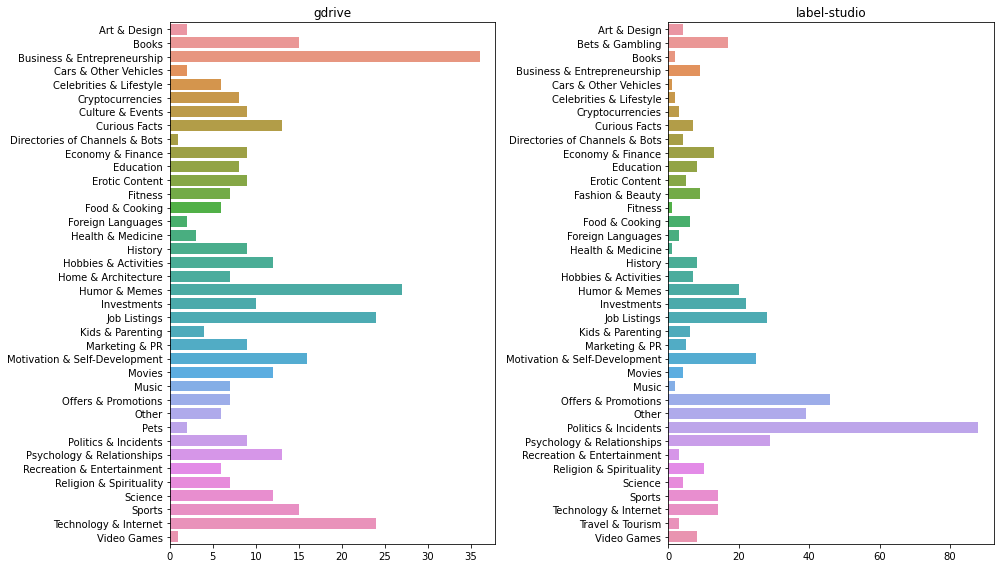

en


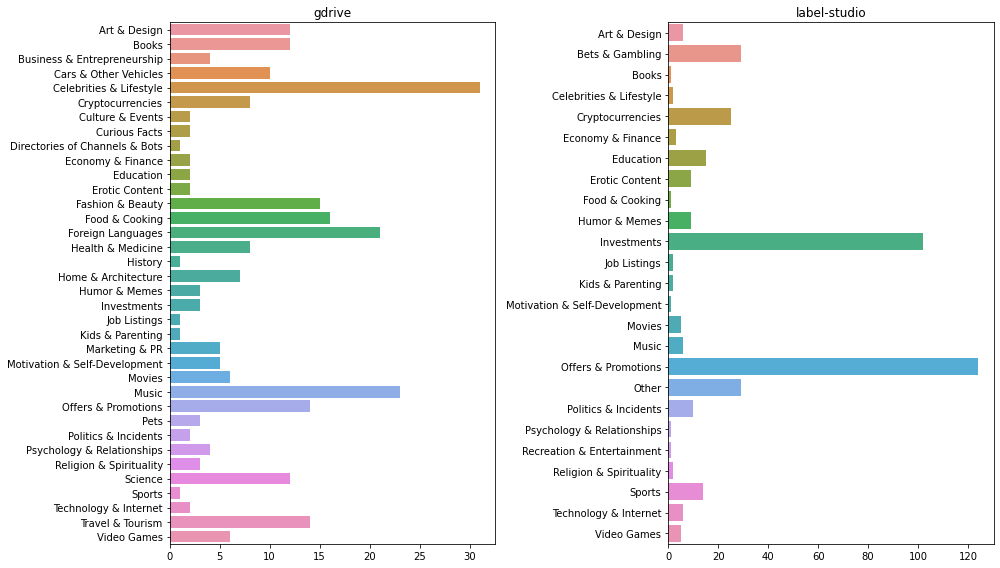

In [778]:
for l in test_data['language'].unique():
    print(l)
    barplots({
        'gdrive': inputs.query(f"language == '{l}'")['topic'],
        'label-studio': test_data.query(f"language == '{l}'")['topic'],
    }, 1, 2, fig_dims=(14,8))

In [779]:
print(inputs.groupby('language')['topic'].nunique())
print(test_data.groupby('language')['topic'].nunique())

language
en    36
ru    38
Name: topic, dtype: int64
language
en    25
ru    38
Name: topic, dtype: int64


### Save combined

In [780]:
comb = pd.concat([inputs, test_data], axis=0)
comb.shape

(1529, 12)

In [781]:
comb.to_csv('data/interim/train_data.csv', index=False)

### Load stopwords

In [782]:
STOPWORDS = {
    'en': 'data/external/en_stopwords.txt',
    'ru': 'data/external/ru_stopwords.txt',
}

In [783]:
stopwords = [Path(f).read_text().strip().split('\n') for l,f in STOPWORDS.items()]

stopwords = sum(stopwords, [])

len(stopwords)

420

## Experiments

**Hyper-parameters:**
- [x] topics: primary only, primary + secondary
- [x] inputs: title, description, posts
- [x] preprocessing: raw, lemmas
- [x] vectorizers: tf-idf, bow
- [x] clf: xgb, nb, etc.

In [784]:
from sklearn.model_selection import train_test_split

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.multioutput import MultiOutputClassifier, ClassifierChain
from sklearn.preprocessing import MultiLabelBinarizer, OneHotEncoder
from sklearn.linear_model import LogisticRegression, ElasticNet
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.tree import ExtraTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.naive_bayes import ComplementNB, MultinomialNB

from xgboost import XGBClassifier

import itertools

In [785]:
class Trainer:
    """ prapre inputs, vectorize texts and run a classifier """
    def __init__(self, language, input_fields, preprocessing, vect, est):
        self.LANG = language
        self.INPUT_FIELDS = input_fields
        self.vect = VECTORIZERS[vect]
        self.vect.preprocessor = lambda x: x
        self.vect.lowercase = False
        self.clf = ESTIMATORS[est]
        assert preprocessing in ['lemma', 'raw']
        self.preprocessing = preprocessing
        if preprocessing == 'lemma':
            self.vect.tokenizer = lang_lemmatizer(language)
        else:
            self.vect.tokenizer = tokenize_text
        
        
    def prepare_data(self, is_final):
        # text inputs and 
        inputs['text'] = inputs.apply(lambda x: prepare_inputs(x, self.INPUT_FIELDS), axis=1)
        test_data['text'] = test_data.apply(lambda x: prepare_inputs(x, self.INPUT_FIELDS), axis=1)
        # split into  train and test
        test_subset = test_data.query(f"language == '{self.LANG}'")
        external_subset = inputs.query(f"language == '{self.LANG}'")
        one,self.test_inputs = train_test_split(test_subset, test_size=TEST_SIZE, random_state=24, shuffle=True,)
        comb_datasets = [external_subset, one, self.test_inputs] if is_final else [external_subset, one]
        self.train_inputs = pd.concat(comb_datasets, axis=0)
        # x and y
        self.y_train = self.train_inputs['topic']
        self.y_test = self.test_inputs['topic']
        self.X_train = self.vect.fit_transform(self.train_inputs['text'])
        self.X_test = self.vect.transform(self.test_inputs['text'])
        
        
    def run_eval(self, final=False):
        """ prepare inputs and run clf evaluation """
        self.prepare_data(final)
        # fit and eval
        self.clf.fit(self.X_train, self.y_train)
        self.predictions = pd.DataFrame({
                    'true': trainer.test_inputs['topics'],
                    'predicted': trainer.clf.predict(trainer.X_test)
                })
        score = self.predictions.apply(lambda x: x['predicted'] in x['true'], axis=1).mean()
        return score

### Set hyper-parameters

In [786]:
TEST_SIZE = 100

In [799]:
INPUTS = [
    'title',
    'description',
    'posts',
]

PREPROCESSING = [
    'raw',
#     'lemma',
]

vect_params = dict(
    max_df=0.4, 
    min_df=3,
    max_features=3000,
    binary=False, 
    ngram_range=(1,1), 
    tokenizer=tokenize_text,
    stop_words=stopwords, 
)
VECTORIZERS = {
    'tfidf': TfidfVectorizer(**vect_params),
    'bow': CountVectorizer(**vect_params),
}


ESTIMATORS = dict(
#     xgb = XGBClassifier(objective='multi:softmax'),
#     forest = RandomForestClassifier(),
#     logreg = LogisticRegression(),
#     knn = KNeighborsClassifier(),
#     tree = ExtraTreeClassifier(),
#     svm = SVC(),
#     linsvm = LinearSVC(),
    cnb = ComplementNB(),
    mnb = MultinomialNB(),
)

In [800]:
input_combinations = [INPUTS] #list(itertools.combinations(INPUTS, r=2)) + [INPUTS]

train_params = list(itertools.product(test_data['language'].unique(), 
                                input_combinations,
                                      PREPROCESSING,
                                VECTORIZERS.keys(), 
                                ESTIMATORS.keys()))

len(train_params)

8

### Run experiments

In [801]:
results = []

for params in tqdm_notebook(train_params, desc='# experiments'):
    trainer = Trainer(*params)
    score = trainer.run_eval()
    params += (score,)
    results.append(params)
                
results = pd.DataFrame(results, columns=['language','input_fields', 'preprocessing','vect', 'est', 'score'])

/Users/rustem.galiullin/miniconda3/envs/tgcat/lib/python3.7/site-packages/ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


# experiments:   0%|          | 0/8 [00:00<?, ?it/s]

/Users/rustem.galiullin/miniconda3/envs/tgcat/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:391: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['cent', 'dr', 'mr', 'per'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
/Users/rustem.galiullin/miniconda3/envs/tgcat/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:391: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['cent', 'dr', 'mr', 'per'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


In [802]:
for l in results['language'].unique():
    print(results.query(f'language == "{l}"').sort_values('score', ascending=False).to_markdown(), end='\n\n')

|    | language   | input_fields                      | preprocessing   | vect   | est   |   score |
|---:|:-----------|:----------------------------------|:----------------|:-------|:------|--------:|
|  3 | ru         | ['title', 'description', 'posts'] | raw             | bow    | mnb   |    0.79 |
|  0 | ru         | ['title', 'description', 'posts'] | raw             | tfidf  | cnb   |    0.71 |
|  2 | ru         | ['title', 'description', 'posts'] | raw             | bow    | cnb   |    0.68 |
|  1 | ru         | ['title', 'description', 'posts'] | raw             | tfidf  | mnb   |    0.6  |

|    | language   | input_fields                      | preprocessing   | vect   | est   |   score |
|---:|:-----------|:----------------------------------|:----------------|:-------|:------|--------:|
|  4 | en         | ['title', 'description', 'posts'] | raw             | tfidf  | cnb   |    0.72 |
|  7 | en         | ['title', 'description', 'posts'] | raw             | bow    | mnb   |

### Review errors

In [803]:
from sklearn.metrics import top_k_accuracy_score

#### Train

In [806]:
trainer = Trainer(
    language = 'en', 
    input_fields = ['posts','description','title'], 
    preprocessing = 'raw',
    vect = 'tfidf', 
    est = 'cnb'
)
s = trainer.run_eval(final=False)
print(s)

0.72


In [807]:
for k in [1,2,3,5]:
    top_k_acc = top_k_accuracy_score(trainer.y_test, trainer.clf.predict_proba(trainer.X_test), 
                                     labels=trainer.clf.classes_,
                                        k=k)
    print(f'Top {k} accuracy: {top_k_acc:.2f}', )

Top 1 accuracy: 0.58
Top 2 accuracy: 0.74
Top 3 accuracy: 0.81
Top 5 accuracy: 0.87


#### Classification report

In [808]:
from sklearn.metrics import classification_report

In [809]:
test_pred = trainer.clf.predict(trainer.X_test)

is_wrong = test_pred != trainer.y_test

errors = trainer.test_inputs[is_wrong]

errors['predicted'] = test_pred[is_wrong]

/Users/rustem.galiullin/miniconda3/envs/tgcat/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


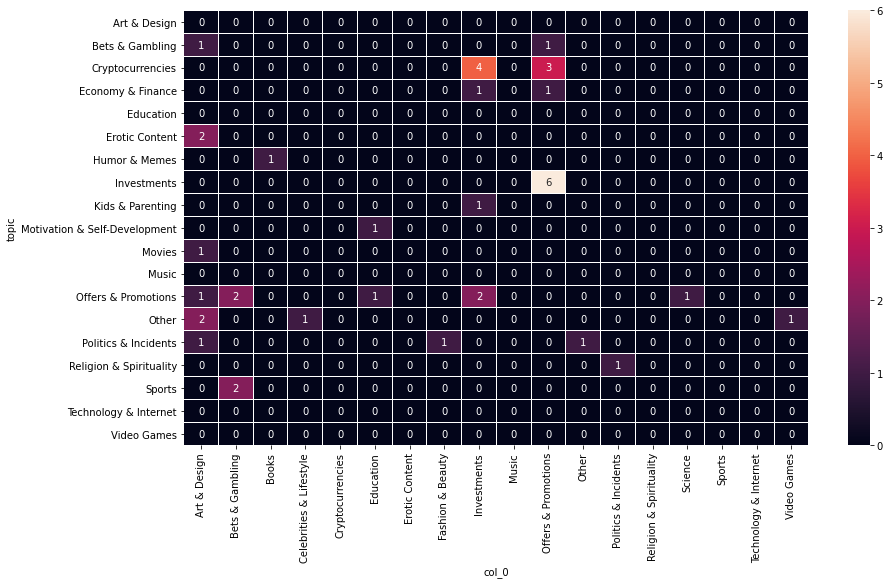

In [810]:
ct = pd.crosstab(trainer.y_test, test_pred)
for i,k in ct.iteritems():
    k[i] = 0


plt.figure(figsize=(14,8))
sns.heatmap(ct, annot=True, linewidths=0.01);

In [811]:
metrics = pd.DataFrame(classification_report(trainer.y_test, test_pred, output_dict=True, zero_division=0)).T

metrics = metrics.query("support > 0").sort_values('f1-score', ascending=True)

print(metrics.to_markdown())

|                               |   precision |   recall |   f1-score |   support |
|:------------------------------|------------:|---------:|-----------:|----------:|
| Movies                        |    0        | 0        |   0        |       1   |
| Politics & Incidents          |    0        | 0        |   0        |       3   |
| Economy & Finance             |    0        | 0        |   0        |       2   |
| Other                         |    0        | 0        |   0        |       4   |
| Humor & Memes                 |    0        | 0        |   0        |       1   |
| Motivation & Self-Development |    0        | 0        |   0        |       1   |
| Kids & Parenting              |    0        | 0        |   0        |       1   |
| macro avg                     |    0.400161 | 0.380037 |   0.348211 |     100   |
| Cryptocurrencies              |    1        | 0.222222 |   0.363636 |       9   |
| Art & Design                  |    0.333333 | 1        |   0.5      |     

#### random examples

In [812]:
row = errors.sample(1).iloc[0]

print('PREDICTED:\n', row['predicted'], end='\n\n')
print('TRUE:\n', row['topics'], end='\n\n')
print('TEXTS:\n', row['text'], end='\n\n')
print(f'TITLE ({row["id"]}):\n', row['title'], end='\n\n')
print('DESCRIPTION:\n', row['description'], end='\n\n')

PREDICTED:
 Offers & Promotions

TRUE:
 ['Investments']

TEXTS:
 🌀OCTA FOREX SIGNALS🌀
Octafx 🌎 we  are the best when it comes leaverge and Forex trading signals, we do account management and also set up legit investment packages for our investors 
Admin @Harryclifordfx3
!!Attention all members 

profit base system Investment is available now 
If any body wants to invest 500$ into my account i give back profit every weekend 350$.
Same ratio like this big investors.
1: For 500$ i return every friday night I return 350$
2: For 1000$ return 700$ every friday night.
3: For 5k$ return 3.5k$ every friday night 
4: For 50k$ return 35k$ every friday night.
5:The contract will be for 6 months.after 6 months contract will be expire.
(Invest is your work .make profit for you is my work)

*One time invest life time earn profit*

📩Contact admin
@Harryclifordfx3
🌐 Binary investment is a financial product where the buyer receives a payout on their investment, based on if the option expires in the mone

In [813]:
def get_topic_features(nb_clf, class_label, top_n=15):
    """ get features with largest log prob for the given class """
    class_i = np.argwhere(nb_clf.classes_ == class_label).squeeze()
    class_coef = nb_clf.feature_log_prob_[class_i]
    top_inds = np.argsort(class_coef)[-top_n:]
    return top_inds

In [814]:
FEATURES = trainer.vect.get_feature_names()
PREDICTED_INDEX = np.argwhere(trainer.clf.classes_ == row['predicted']).squeeze()

# get top features that triggered prediction
x = trainer.vect.transform([row['text']]).toarray()[0]
f = ( trainer.clf.feature_log_prob_ * x.T)[PREDICTED_INDEX]
top_keywords = [FEATURES[i] for i in np.argsort(f)[::-1][:15]]


true_inds = get_topic_features(trainer.clf, row['topic'],)
true_keywords = [FEATURES[i] for i in true_inds]

predicted_inds = get_topic_features(trainer.clf, row['predicted'],)
predicted_keywords = [FEATURES[i] for i in predicted_inds]


print('TRUE CLASS: ', row['topic'])
print(true_keywords, end='\n\n')
print(f'PREDICTED CLASS: {row["predicted"]}')
print(predicted_keywords, end='\n\n')
print('EXAMPLE')
print(top_keywords)

TRUE CLASS:  Investments
['fiscal', 'cdbykmcbil', 'gained', 'sami', 'gains', 'oujqq', 'vd', 'bgutmqp', 'wvxbntganp', 'bx', 'wxdpc', 'weakness', 'alts', 'bouncing', 'volatile']

PREDICTED CLASS: Offers & Promotions
['beneficiary', 'wages', 'ease', 'proven', 'cbpk', 'klever', 'klv', 'lvl', 'harga', 'attain', 'recharge', 'cryptogamer', 'cheating', 'holders', 'mentor']

EXAMPLE
['invest', 'return', 'investment', 'night', 'every', 'profit', 'get', 'automatically', 'tp', 'gold', 'contract', 'binary', 'option', 'money', 'months']


#### Fixes

**fixes**
- [ ] update stopwords
- [x] lemmas
- [x] remove single char terms
- [x] compare feature keywords against topic keywords
- [x] multi-class problem
- [x] only eng and rus chars
- [x] measure accuracy with top N predictions
- [x] use full data to train last
- [ ] sample weights for secondary
- [ ] bow to torchscript
- [x] apply sum normalization only then min prob threshold
- [x] fix when nothing predicted (add zero vectors as Other)
- [x] remove URL for lang detection

## Save models

In [815]:
from torch import nn
import torch
from torch.nn import functional as F
from typing import Dict, List, Tuple

In [816]:
class NaiveBayes(nn.Module):
    """ Implement Multinomial and Complement NB inference """
    def __init__(self, nb, clf,):
        super().__init__()
        assert nb in ['cnb','mnb']
        self.nb = nb
        self.feature_log_prior = nn.Parameter(torch.tensor(clf.feature_log_prob_), requires_grad=False)
        self.class_log_prior = nn.Parameter(torch.tensor(clf.class_log_prior_), requires_grad=False)
        self.class_labels = clf.classes_.tolist()
        

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        jll = torch.matmul(x.double(), self.feature_log_prior.T)
        if self.nb == 'cnb':
            if self.class_log_prior.size(0) == 1:
                jll += self.class_log_prior
        else:
            jll += self.class_log_prior
        log_prob = torch.logsumexp(jll, dim=1)
        log_prob = jll - torch.atleast_2d(log_prob).T
        prob = torch.exp(log_prob)
        return prob


class TextVectorizer(nn.Module):
    """ vectorize text using tf-idf or bow """
    def __init__(self, vect, vectorizer):
        super().__init__()
        assert vect in ['bow','tfidf']
        self.vocab = {k: torch.tensor(v) for k,v in vectorizer.vocabulary_.items()}
        self.vocab_len = len(self.vocab)
        if vect == 'tfidf':
            self.idf_diag = nn.Parameter(
                torch.tensor(vectorizer._tfidf._idf_diag.toarray()), 
                requires_grad=False)
            self.sublinear_tf = vectorizer.sublinear_tf
            self.norm = vectorizer.norm
            self.use_idf = vectorizer.use_idf
        else:
            self.idf_diag = nn.Parameter(torch.eye(self.vocab_len))
            self.sublinear_tf = False
            self.norm = None
            self.use_idf = False
            
        

    def count_vocab(self, doc: List[str]) -> torch.Tensor:
        """ return counts of each word from the vocab """
        feature_counter = torch.zeros(self.vocab_len, dtype=torch.long)
        for feature in doc:
            n = self.vocab.get(str(feature), torch.tensor(-1))
            if n.item() != -1:
                feature_idx = self.vocab[str(feature)]
                feature_counter[feature_idx] += 1
        return feature_counter
        
        
    def forward(self, batch: List[List[str]]) -> torch.Tensor:
        doc_counts: List[torch.Tensor] = [self.count_vocab(doc) for doc in batch]
        X = torch.stack(doc_counts,)
        if self.sublinear_tf:
            X = torch.log(X.double())
            X += 1
        if self.use_idf:
            X = torch.matmul(X.double(), self.idf_diag)
        if self.norm is not None:
            p = float(self.norm[-1])
            X = F.normalize(X.double(), p=p, dim=1)
        return X
    

class TgCat(nn.Module):
    """ vectorize input texts, classfy topics and decode predictions """
    def __init__(self, vect, clf, top_k=3,):
        super().__init__()
        self.vect = vect
        self.clf = clf
        self.top_k = top_k
        
        
    def select_top_classes(self, probs: torch.Tensor) -> Dict[str,float]:
        """ select classes with at least min prob and return a normalized dict mapping """
        if self.clf.nb == 'cnb':
            if probs.std(0) < 0.0001:
                return {"Other": 1.0}
        else:
            if probs.max() < 0.1:
                return {"Other": 1.0}
        inds_desc = torch.argsort(probs, 0, descending=True)
        top_k = min((probs > probs.mean()).sum(), torch.tensor(self.top_k))
        target_i = inds_desc[:top_k]
        target_p = probs[target_i]
        target_p = target_p / target_p.sum()
        result: List[Tuple[str, float]] = [
            (self.clf.class_labels[target_i[i].item()], target_p[i].item())
            for i in range(target_p.size(0))
        ]
        return dict(result)
    
    
    def get_prob(self, batch: List[List[str]]) -> torch.Tensor:
        embeddings = self.vect(batch)
        probs = self.clf(embeddings)
        return probs
        
    
    def forward(self, batch: List[List[str]]) -> List[Dict[str, float]]:
        probs = self.get_prob(batch)
        top_predictions = [self.select_top_classes(probs[i]) for i in range(probs.size(0))]
        return top_predictions

### Test

In [834]:
V = 'tfidf'
E = 'cnb'
L = 'en'

trainer = Trainer(
    language = L, 
    input_fields = ['posts','description','title'], 
    preprocessing = 'raw',
    vect = V, 
    est = E,
)
_ = trainer.run_eval(final=False)

tgcat = TgCat(TextVectorizer(V, trainer.vect), NaiveBayes(E, trainer.clf), top_k=3)

In [835]:

batch = trainer.test_inputs['text'].apply(tokenize_text).tolist()

predictions = tgcat(batch)

In [836]:
v = tgcat.vect(batch)
p = tgcat.clf(v)

In [837]:
tgcat([['a','s','d'], [""], ["other", 'other', 'ttt'], ["чгк", "нияег", "его"]])

[{'Other': 1.0}, {'Other': 1.0}, {'Other': 1.0}, {'Other': 1.0}]

In [841]:
i = random.randint(0, len(batch) - 1)

print('PREDICTED', predictions[i], end='\n\n')
print('TOKENS', batch[i])

PREDICTED {'Investments': 0.5513697360850658, 'Offers & Promotions': 0.44863026391493427}

TOKENS ['premium', 'group', 'option', 'calls', 'join', 'sure', 'free', 'free', 'calls', 'recover', 'karna', 'free', 'channel', 'join', 'our', 'channel', 'and', 'recover', 'all', 'your', 'losses', 'we', 'believe', 'in', 'consistent', 'profits', 'our', 'expiry', 'special', 'trades', 'details', 'appotyre', 'ce', 'profit', 'rs', 'bandhanbank', 'pe', 'profit', 'total', 'profit', 'rs', 'check', 'out', 'our', 'channel', 'highlights', 'of', 'our', 'channel', 'daily', 'intraday', 'future', 'calls', 'intra', 'pos', 'stock', 'options', 'index', 'options', 'capital', 'required', 'earn', 'daily', 'profit', 'monthly', 'profit', 'assured', 'lakhs', 'join', 'channel', 'fast', 'gann', 'price', 'analysis', 'nifty', 'long', 'from', 'reversal', 'got', 'nifty', 'future', 'this', 'week', 'road', 'map', 'bearish', 'for', 'tcl', 'last', 'savour', 'is', 'yearly', 'open', 'banknifty', 'future', 'weekly', 'road', 'map', 'a

### Final training, convert and save

In [842]:
from sklearn.preprocessing import normalize

In [843]:
prediction_params = {
    'top_k': 3
}

In [844]:
for l in results['language'].unique():
    subset = results.query(f"language == '{l}'")
    best_id = subset['score'].idxmax()
    best_params = subset.loc[best_id].to_dict()
    print(l, 'best', best_params)
    del best_params['score']
    # for last training increase train by test
    trainer = Trainer(**best_params)
    s = trainer.run_eval(final=True)
    print(l, s)
    # save text vectorizer
    vect_scripted = torch.jit.script(TextVectorizer(best_params['vect'], trainer.vect), )
    tokenizer = tokenize_text if best_params['preprocessing'] == 'raw' else lang_lemmatizer(l)
    batch = trainer.test_inputs['text'].apply(tokenizer).tolist()
    vect_out = vect_scripted(batch)
    src_vects = trainer.X_test.toarray()
    assert np.allclose(src_vects, vect_out.numpy())
    vect_scripted.save(f"models/trained/embed/{l}_{best_params['vect']}_script.pt")
    # save classifier
    nb_scripted  = torch.jit.script(NaiveBayes(best_params['est'], trainer.clf))
    nb_out = nb_scripted(torch.tensor(trainer.X_test.toarray(), dtype=torch.double))
    assert np.allclose(trainer.clf.predict_proba(trainer.X_test), nb_out.numpy())
    nb_scripted.save(f"models/trained/classify/{l}_{best_params['est']}_script.pt")
    # save tgcat
    tgcat = torch.jit.script(TgCat(vect_scripted, nb_scripted, **prediction_params))
    path = f'models/trained/tgcat/{l}_tgcat.pt'
    torch.jit.save(tgcat, path)
    print('saved to', path)

ru best {'language': 'ru', 'input_fields': ['title', 'description', 'posts'], 'preprocessing': 'raw', 'vect': 'bow', 'est': 'mnb', 'score': 0.79}
ru 0.94
saved to models/trained/tgcat/ru_tgcat.pt
en best {'language': 'en', 'input_fields': ['title', 'description', 'posts'], 'preprocessing': 'raw', 'vect': 'tfidf', 'est': 'cnb', 'score': 0.72}
en 0.94
saved to models/trained/tgcat/en_tgcat.pt


### Check file sizes

In [845]:
!du -hm models/trained/*/* | sort -nr

81	models/trained/tgcat/en_tgcat.pt
81	models/trained/embed/ru_tfidf_script.pt
81	models/trained/embed/en_tfidf_script.pt
37	models/trained/tgcat/ru_tgcat.pt
37	models/trained/embed/ru_bow_script.pt
1	models/trained/embed/ru_bow.txt
1	models/trained/classify/ru_mnb_script.pt
1	models/trained/classify/ru_cnb_script.pt
1	models/trained/classify/en_cnb_script.pt
